# T05 Project 2 - Analysis of Suicide Rates

## Philip Baker, Bharath Prabhu

## 1. Big Picture

### Motivation Behind the Project

Understanding socio-economic indicators that lead to a heightened probability of suicide within a certain population has clear value given the importance of mental health and suicide prevention. It is obvious that a model, if one could exist, that could accurately predict who will or will not commit suicide would be of immeasurable value to the world. We understand that given the complexity of the problem space as well as working within the constraints of this data set and this course will not allow us to create such a model, or even close. However, using the given data, we feel that we may be able to begin to peer into how different socio-economic factors influence a population’s likelihood of suicide. The utter importance of the problem space drew us in and the possibility of gaining any further understanding it using machine learning excites us.

### A peek into the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
pd.options.display.html.use_mathjax = False
from sklearn import *
import seaborn as sns
import warnings

%matplotlib inline

In [2]:
# load the data in and read the data
suicide_rates = pd.read_csv('suicide-rates.csv')

In [3]:
suicide_rates.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:
suicide_rates.shape

(27820, 12)

There are a total of 27,820 rows in the dataset. Each row represents information on suicide for various age groups of a particular year, country and sex (ie. each row is uniquely identified by 'country, year, sex and age'. There are a total of 12 columns in the dataset - country, year, sex, age, number of suicides, population, suicide_rate, country-year, HDI, GDP, GDP_per_capita, generation_type. Most of these columns will be used as features (or more features may be engineered) in our models for prediction.

### Question we are interested in answering

    What features help best predict 'Suicide_Rate_per_100k' for a particular country in a given year for an 'Age_Group'?

## 2. Get the Data 

### Data Cleaning

In [5]:
new_cols = ['Country', 'Year', 'Sex', 'Age_Group', 'Num_Suicides', 'Population', 'Suicide_Rate_per_100k',
            'Country_Year', 'HDI_for_year', 'GDP_for_year', 'GDP_per_capita_for_year', 'Generation_Type']
suicide_rates.columns = new_cols
suicide_rates.head()

,Country,Year,Sex,Age_Group,Num_Suicides,Population,Suicide_Rate_per_100k,Country_Year,HDI_for_year,GDP_for_year,GDP_per_capita_for_year,Generation_Type
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [6]:
suicide_rates.isna().sum(axis = 0)

Country                        0
Year                           0
Sex                            0
Age_Group                      0
Num_Suicides                   0
Population                     0
Suicide_Rate_per_100k          0
Country_Year                   0
HDI_for_year               19456
GDP_for_year                   0
GDP_per_capita_for_year        0
Generation_Type                0
dtype: int64

We can see that the column of HDI has many NaN values showing that not all countries have data with regards to the Human Development Index for a particular year. This is because HDI was only concretely measured by the United Nations starting from the year 1990 and therefore, for data pertaining to years prior to 1990, no HDI values are present.

In [7]:
suicide_rates[suicide_rates['HDI_for_year'].isnull()].tail()

,Country,Year,Sex,Age_Group,Num_Suicides,Population,Suicide_Rate_per_100k,Country_Year,HDI_for_year,GDP_for_year,GDP_per_capita_for_year,Generation_Type
27755,Uzbekistan,2009,female,75+ years,7,318983,2.19,Uzbekistan2009,NaN,"33,689,223,673",1332,Silent
27756,Uzbekistan,2009,female,35-54 years,65,3263931,1.99,Uzbekistan2009,NaN,"33,689,223,673",1332,Boomers
27757,Uzbekistan,2009,female,55-74 years,15,1105076,1.36,Uzbekistan2009,NaN,"33,689,223,673",1332,Silent
27758,Uzbekistan,2009,male,5-14 years,37,2805898,1.32,Uzbekistan2009,NaN,"33,689,223,673",1332,Generation Z
27759,Uzbekistan,2009,female,5-14 years,18,2678474,0.67,Uzbekistan2009,NaN,"33,689,223,673",1332,Generation Z


Based on the above table, we can see that even though the year is beyond 1990 there still isn't any data present for HDI. The HDI is an important metric that measures quality and standard of living and could be an important feature in any model that we use. Therefore, we shall extract a separate dataset from the UN website that contain values of the HDI for years after 1990 and populate the dataset accordingly.

In [8]:
# load the data in and read the data ==> Source: http://www.hdr.undp.org/en/data
HDI_data = pd.read_csv('HDI_data.csv')
HDI_data.head()

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


Only for a year >= 1990 or a year <= 2017 can HDI data be populated. Furthermore, the country in the HDI_dataset must be present in our dataset. Therefore, we will first extract the common countries and appropriate years

### Common Countries

In [9]:
HDI_countries = HDI_data.loc[:,'Country'].values
HDI_countries = [country.strip() for country in HDI_countries]
HDI_data.Country = [country.strip() for country in HDI_countries]

In [10]:
suicide_countries = suicide_rates.loc[:,'Country'].drop_duplicates().values

In [11]:
common_countries = np.intersect1d(suicide_countries, HDI_countries)

Now that we have the common countries between the 2 datasets, we can proceed to populate the NaN values in the suicide_rates dataframe

In [12]:
NA_indices = suicide_rates[suicide_rates['HDI_for_year'].isnull()].index.values

In [13]:
def populate_HDI_vals(df1, df2, array, common_array):
    '''
    Given 2 dataframes and 2 arrays of indices, the function returns the first dataframe
    which has NaN values in the HDI_for_year column populated with values from the second
    dataframe
    '''
    for row in array:
        if(pd.isnull(df1.loc[row]['HDI_for_year'])):
            
            # get year and country of NaN value
            year = df1.loc[row]['Year']
            country = df1.loc[row]['Country']
            
            # find index of row with correct HDI value
            if(country in common_array):
                index = df2[df2.Country == country].index.astype(int)[0]
                if(year >= 1990 and year <= 2017):
                    HDI_val = df2.loc[index][str(year)]
                    df1.loc[row,'HDI_for_year'] = HDI_val
        
    return(df1) 

In [14]:
suicide_rates = populate_HDI_vals(suicide_rates, HDI_data, NA_indices, common_countries)

In [15]:
suicide_rates.isna().sum(axis = 0)

Country                       0
Year                          0
Sex                           0
Age_Group                     0
Num_Suicides                  0
Population                    0
Suicide_Rate_per_100k         0
Country_Year                  0
HDI_for_year               5194
GDP_for_year                  0
GDP_per_capita_for_year       0
Generation_Type               0
dtype: int64

We can see that even after populating from the HDI dataset from the UN website, we still have close to 5194 rows of NA values for HDI. Therefore, we are going to populate these rows with the median HDI value of each country so as not to tamper with the distribution of the original data.

In [16]:
def median_HDI_country(df):
    '''
    Given 2 dataframes the function returns a dictionary with a key value pair
    of the format <country : median_HDI_val>, where median vals are extracted from df2
    and countries extracted from df1
    '''
    final_dict = {}
    countries = df.Country.drop_duplicates().values
    for country in countries:
        median_HDI_country = df[df.Country == country].median(axis = 0)['HDI_for_year']
        if(pd.notna(median_HDI_country)):
            final_dict[country] = median_HDI_country
    return(final_dict)

In [17]:
warnings.filterwarnings('ignore')
median_dict = median_HDI_country(suicide_rates)

In [18]:
# These 2 countries are measured by UN but named differently and so are added separately to the dictionary
dominica_median = HDI_data[HDI_data.Country == 'Dominica'].median(axis = 1).values[0]
skorea_median = HDI_data[HDI_data.Country == "Korea (Republic of)"].median(axis = 1).values[0]
median_dict['Dominica'] = dominica_median
median_dict['Republic of Korea'] = skorea_median

In [19]:
NA_indices = suicide_rates[pd.isna(suicide_rates.HDI_for_year)].index.values

In [20]:
def populate_median(dictionary, df, array):
    '''
    Given an array of indices and a dictionary of median vals for each country, the function
    populates the median vals into the dataframe for the appropriate countries
    '''
    for row in array:
        country = df.loc[row]['Country']
        if(country in dictionary.keys()):
            median_val  = dictionary[country]
            df.loc[row,'HDI_for_year'] = median_val
    return(df)

In [21]:
suicide_rates = populate_median(median_dict, suicide_rates, NA_indices)

In [22]:
suicide_rates.isna().sum(axis = 0)

Country                      0
Year                         0
Sex                          0
Age_Group                    0
Num_Suicides                 0
Population                   0
Suicide_Rate_per_100k        0
Country_Year                 0
HDI_for_year               624
GDP_for_year                 0
GDP_per_capita_for_year      0
Generation_Type              0
dtype: int64

In [23]:
suicide_rates[pd.isna(suicide_rates.HDI_for_year)].Country.drop_duplicates()

1258                     Aruba
15678                    Macau
19680              Puerto Rico
21260    Saint Kitts and Nevis
21932               San Marino
Name: Country, dtype: object

These countries do not have HDI values as they are not measured by the UN and hence these rows will be removed from the dataset (ie. data for 4 countries will be removed).

In [24]:
suicide_rates = suicide_rates.dropna()
suicide_rates.shape

(27196, 12)

In [25]:
# there are certain cols that are unncessary ==> Country_Year
suicide_rates = suicide_rates.drop('Country_Year', axis = 1)

In [26]:
# Remove commas in strings
suicide_rates['GDP_for_year'] = suicide_rates['GDP_for_year'].str.replace(",", "")

# Change string to numbers
suicide_rates['GDP_for_year'] = pd.to_numeric(suicide_rates['GDP_for_year'])

Before we begin to explore the data, we should probably split the data into a train and test set and only explore the train data so that our model does not carry any bias from possible associations we might see with the test data

In [27]:
Y = suicide_rates["Suicide_Rate_per_100k"]
X = suicide_rates.drop(columns = ["Suicide_Rate_per_100k"])

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## 3. Explore the Data to get insights

Lets first explore the distribution of suicide rates across various countries in the given time span...

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Suicide Rate per 100k')]

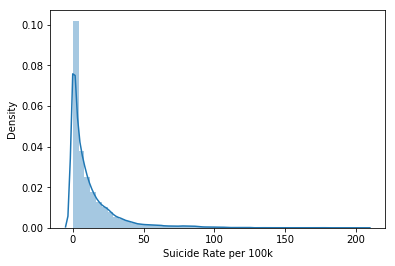

In [29]:
suicide_rate_plot = sns.distplot(y_train)
suicide_rate_plot.set(xlabel = 'Suicide Rate per 100k', ylabel = 'Density')

We see that the distribution of suicide rates in the dataset is heavily right skewed with values of suicide rates ranging from 0 to 204. This large range of values dictates to us that finding a model that is able to predict suicide rates with a very low value of RMSE is crucial as it must be meaningful for countries with very low or high suicide rates

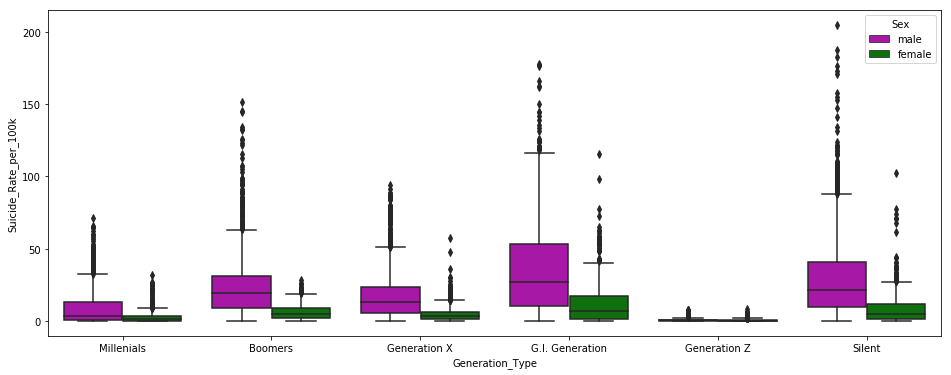

In [30]:
plt.figure(figsize=(16, 6))
train_data = pd.concat([X_train, y_train], axis = 1)
sns.boxplot(x="Generation_Type", y="Suicide_Rate_per_100k",
            hue="Sex", palette=["m", "g"],
            data=train_data, width = 0.8)

What is interesting to note from above is that my generation, Generation Z seems to have the lowest suicide rate, across gender!

However, the Silent and G.I Generation, which are the generations born between 1900 - 1920 & 1920-1940 have the highest suicide rates. This may be the case due to the post-traumatic stress disorder and various economic difficulties experienced post World War 2

Lets see how the number of suicides itself has been changing over time...

In [31]:
X_train_per_year = X_train.groupby('Year').sum()

Text(0.5, 0, 'Year')

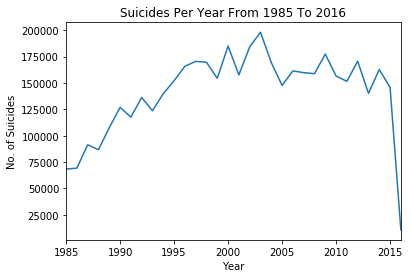

In [32]:
X_train_per_year['Num_Suicides'].plot()
plt.title('Suicides Per Year From 1985 To 2016')
plt.ylabel('No. of Suicides')
plt.xlabel('Year')

We can see that the number of suicides has remained relatively constant for close to 20 years from 1995 to 2015 with some fluctuations until a very sharp decrease. There is a prevalent notion that men commit suicide at a higher rate than women. Lets see how these suicides break up by gender.

In [33]:
X_train_by_gender = X_train.groupby(['Year','Sex']).sum()

Text(0.5, 0, 'Year')

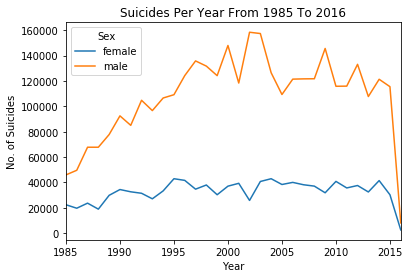

In [34]:
X_train_by_gender.pivot_table('Num_Suicides', index='Year', columns='Sex', aggfunc='sum').plot()
plt.title('Suicides Per Year From 1985 To 2016')
plt.ylabel('No. of Suicides')
plt.xlabel('Year')

From the plot above we can see that men commit suicide at numbers that are almost 3 to 4 times more than women. Lets start looking for interesting correlations in the quantitative variables of the data to see if there are certain features that may impact suicide rates significantly

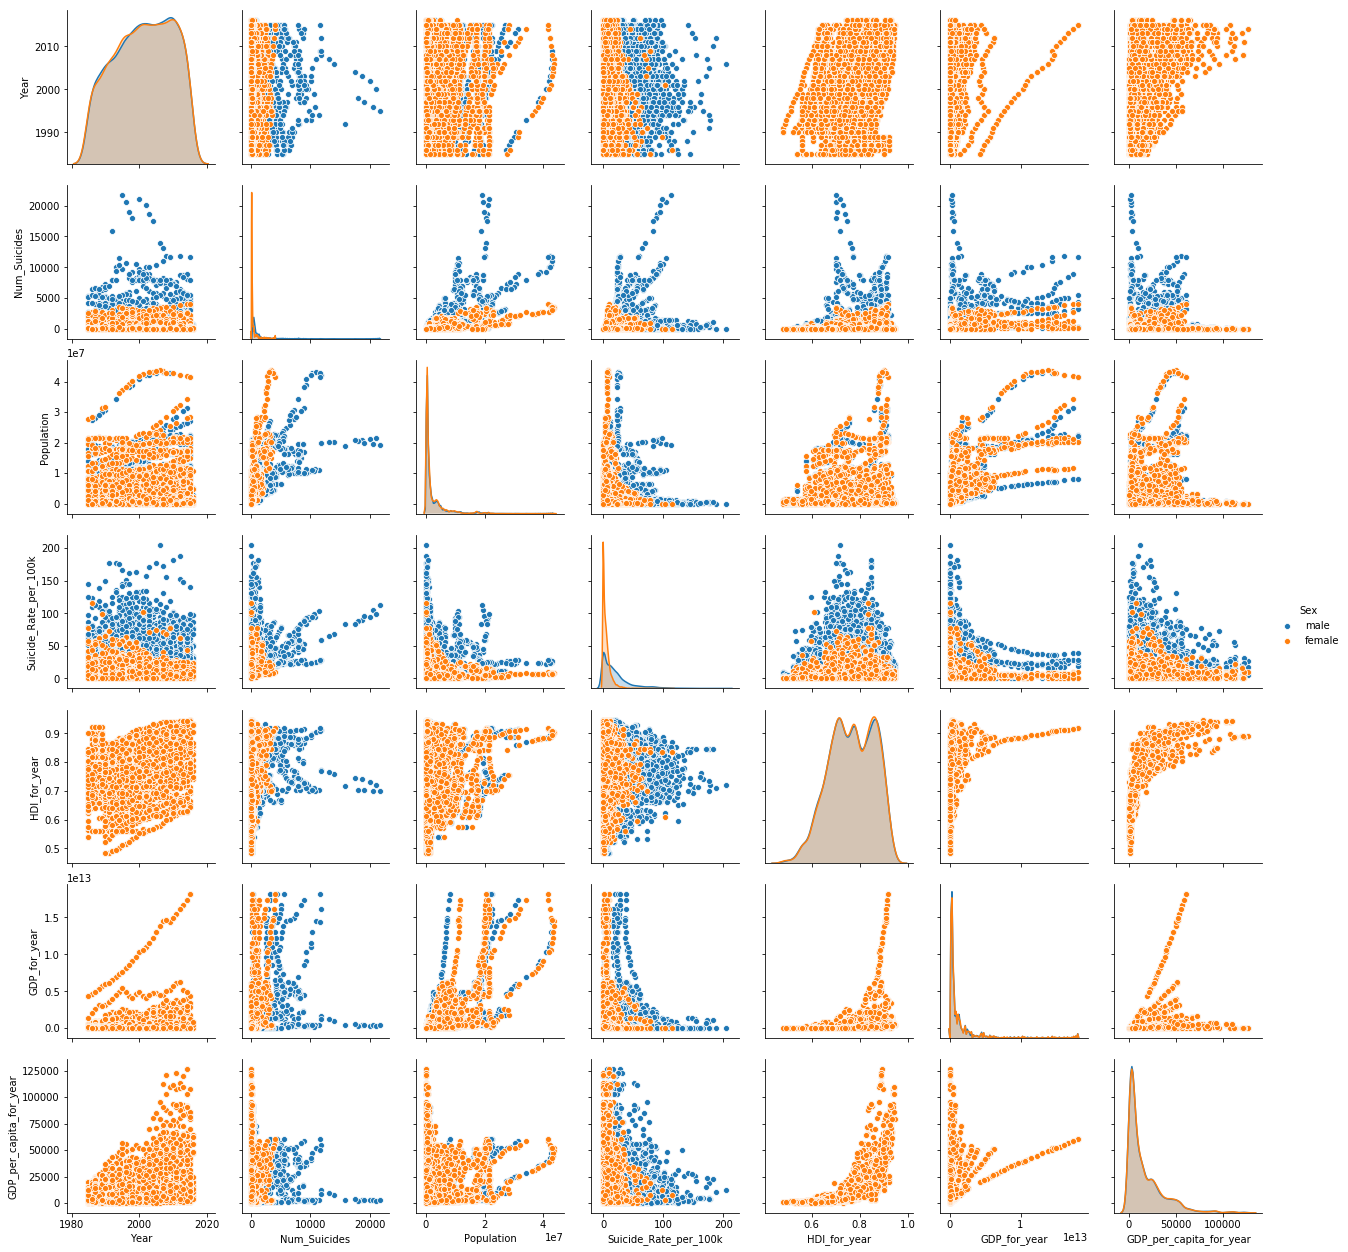

In [35]:
quant_cols = ['Year', 'Num_Suicides', 'Population', 'Suicide_Rate_per_100k', 'HDI_for_year', 'GDP_for_year', 
              'GDP_per_capita_for_year']

# we can use the labels from the train data and explore relationships
train_data = pd.concat([X_train, y_train], axis = 1)
sns.pairplot(train_data[quant_cols + ['Sex']], hue="Sex")

The above pairwise correlation plots have a few of very interesting relationships to note. 

1. Firstly, Lets look at the relationship between HDI_for_year and GDP_per_capita_per_year. We see that there is an almost exponential relationship where a small increase in GDP_per_capita_per_year when its low can have a result in a significant increase in HDI_per_year. However as GDP_per_capita_per_year reaches higher levels we see that there is diminishing returns where the increase in HDI_per_year is minimal. 


2. Secondly, we see that there is a strong normal distribution seen in the relationship between HDI_per_year and Suicide_Rate_per_100k. Even though HDI seems to rise initially suicide_rates tend to rish as well and then slowly fall as after.


3. Thirdly, notice the relationship between Year and Suicide_Rate_per_100k. We see that suicide_rates for women have had a marginal decrease over time, whereas the rates have fluctuating far more wildly for men.


Lets try a correlation heatmap and find out if there are more interesting variables or features to note..

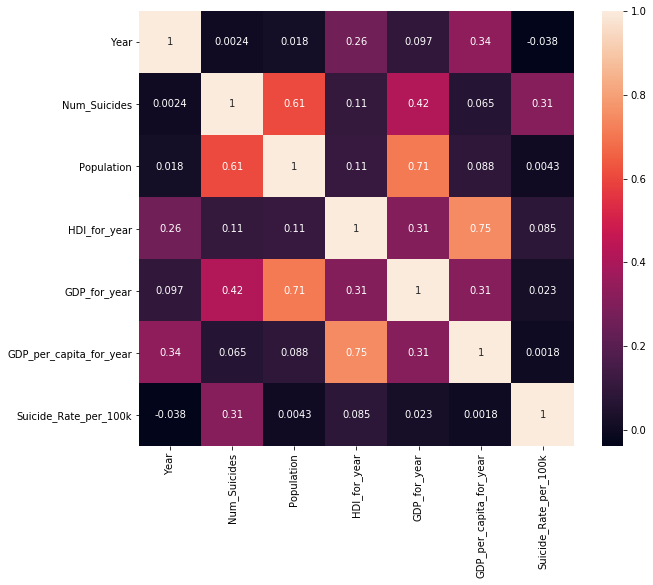

In [36]:
plt.figure(figsize =(10,8))
corrmat = train_data.corr()
sns.heatmap(corrmat, square=True, annot=True, cbar=True);

Based on on the above correlation heat map, we can see that HDI_for_year, has a strongest correlation with Suicide_Rate_per_100k. Furthermore, it also has a very positive correlation with GDP_per_capita_for_year. It was probably a good idea then, that we did not disregard this variable. We also see that there is a very strong correlation between the number of suicides and the population of a country. This maybe perhaps indicative of an association where if more people live in a country, there might be a greater disregard to mental health and suicides.

A few features that we should take note of are HDI_for_year, Population, GDP_per_capita_per_year and all this is excluding the categorical variables!

Since the data is already prepped with populating / removing missing values and a split of the training and testing data, lets proceed and start exploring models that can predict the 'suicide_rate_per_100k'

## 4. Explore many different models and short-list the best ones

Since this project is primarily dealing with a prediction task in trying to predict the 'Suicide_Rate_per_100k', there are a limited number of models that we can use. However we will attempt to conduct feature engineering that will hopefully output better predictions without overfitting on the training data.

### Model 1 : Linear Regression

Since there are several columns that contain categorical variables, we shall encode them as binary variables (1 if present, 0 if not present). For prediction tasks, we will primarily be using RMSE as the metric of choice in evaluating the fit of our models

In [37]:
X_train_encoded = pd.get_dummies(X_train)
X_train_encoded.shape

(18221, 116)

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# linear model on train data --> 5 fold cross validation
lm_cv = cross_validate(linear_model.LinearRegression(), X_train_encoded, y_train, scoring = 'neg_mean_squared_error',cv=5)

In [39]:
neg_train_MSE = lm_cv['train_score'].mean()
train_RMSE = (-neg_train_MSE)**0.5
train_RMSE

12.691235665481518

In [40]:
neg_test_MSE = lm_cv['test_score'].mean()
test_RMSE = (-neg_test_MSE)**0.5
test_RMSE

12.79015627984851

The training RMSE of a simple linear regression model on all the variables is roughly 12.69 whereas the test RMSE is roughly 12.79 on a 5-fold cross validated linear model. This means that the spread of the residuals on either side of the model fit is roughly 12.79. 12.79 is quite a large range for the suicide_rate_per_100k. Can we do better?

NOTE: We want to fit the best model possible on cross validated train data before using the test data and therefore have not and will not touch the test data until we finalize our model

### Model 2 : Linear Regression with a Lasso Regularizer

In [41]:
X_train_encoded.shape

(18221, 116)

After the binary encoding of the categorical variables, we see that there are 116 possible features. Perhaps there are too many such features in the dataset. One way in which we can reduce the number of features and see if the remaining features fit the data well is through a Lasso (L1) Regularizer

In [42]:
from sklearn.linear_model import LassoCV

lm_l1_cv = LassoCV(cv=5, alphas = [0.001, 0.01, 0.1]).fit(X_train_encoded, y_train)
RMSE = (((lm_l1_cv.predict(X_train_encoded) - y_train)**2).mean())**0.5
RMSE

12.694713327822853

In [43]:
lm_l1_cv.coef_[lm_l1_cv.coef_ != 0].shape

(111,)

Wow! 

Notice that an L1 regularizer when cross validated on the training data gives us an RMSE that is almost the same as the RMSE evaluated on the linear model but with 5 fewer features. This helps us to reduce the dimension of the dataset and do feature engineering far more easily. Lets see which are the features whose coefficients evaluate to 0, and remove them from the dataset.

In [44]:
zero_feature_indices = np.where(lm_l1_cv.coef_ == 0)[0].tolist()
X_train_encoded.columns[zero_feature_indices]

Index(['Country_Argentina', 'Country_Cabo Verde', 'Country_Romania',
       'Sex_male', 'Generation_Type_Millenials'],
      dtype='object')

In [45]:
X_train_enc_reduced = X_train_encoded.drop(columns = X_train_encoded.columns[zero_feature_indices])


### Feature Engineering

Possible features that we thought might be useful in predicting a a country's suicide_rate_per_100k for a year might be the previous year's suicide_rate grouped by various demographics. Since economic development or any other metrics are very unlikely to show huge improvements in the short span of just one year, a previous year's average suicide_rate may be a very good feature in predicting the next year's suicide_rate. 

The following 3 functions add three features related to suicide rate.

    1. Previous year's average suicide rate
    2. Previous year's average suicide rate for the middle 4 generations --> they are the largest population of any country
    3. Previous year's average suicide rate for each gender (EDA section showed that gender does affect suicide rate)

#### Previous year's average suicide rate

In [46]:
def get_prev_year_suicide_rate(suicide_rates):
    '''
    Determines the average suicide rate for each country in the previous year
    '''
    country_years = suicide_rates.groupby(['Country','Year'])

    for cyg, g in country_years: 
        
        avg = g['Suicide_Rate_per_100k'].mean()

        next_year_ind = suicide_rates.loc[(suicide_rates['Country']==cyg[0]) \
                                          & (suicide_rates['Year']==cyg[1]+1)].index
        if len(next_year_ind) > 0:
            suicide_rates.loc[next_year_ind, 'prev_avg_suicide_rate'] = avg
            
       
    return suicide_rates

#### Previous year's average suicide rate for the middle four age ranges

In [47]:
def get_middlegen_prev_suicide_rate(suicide_rates):
    '''
    Determines the average suicide rate excluding the 
    youngest age group for each country in the previous year
    '''
    country_years = suicide_rates.groupby(['Country','Year'])

    for cyg, g in country_years: 
        
        avg = g.loc[(g['Age_Group'] != '5-14 years') & (g['Age_Group'] != '75+ years')] \
                        ['Suicide_Rate_per_100k'].mean()

        next_year_ind = suicide_rates.loc[ (suicide_rates['Country']==cyg[0]) \
                            & (suicide_rates['Year']==cyg[1]+1)].index
        if len(next_year_ind) > 0:
            suicide_rates.loc[next_year_ind, 'prev_middlegen_avg_suicide_rate'] = avg
            
    return suicide_rates

#### Previous year's average suicide rate for each sex

In [48]:
def get_prev_sex_suicide_rate(suicide_rates):
    '''Determines the average suicide rate for males in each country in the previous year'''
    country_years = suicide_rates.groupby(['Country', 'Year', 'Sex'])

    for cyg, g in country_years: 
        
        avg = g['Suicide_Rate_per_100k'].mean()

        next_year_ind = suicide_rates.loc[(suicide_rates['Country']==cyg[0]) \
                                          & (suicide_rates['Year']==cyg[1]+1) \
                                          & (suicide_rates['Sex']==cyg[2])].index
        if len(next_year_ind) > 0:
            suicide_rates.loc[next_year_ind, 'prev_sex_avg_suicide_rate'] = avg
            
       
    return suicide_rates


#### Calculate new features

In [49]:
suicide_rates_new = suicide_rates.copy()
suicide_rates_new = suicide_rates_new.sort_values([ 'Country', 'Year','Sex', 'Age_Group'])
suicide_rates_new = suicide_rates_new.reset_index(drop=True)
suicide_rates_new.head()

,Country,Year,Sex,Age_Group,Num_Suicides,Population,Suicide_Rate_per_100k,HDI_for_year,GDP_for_year,GDP_per_capita_for_year,Generation_Type
0,Albania,1987,female,15-24 years,14,289700,4.83,0.676,2156624900,796,Generation X
1,Albania,1987,female,25-34 years,4,257200,1.56,0.676,2156624900,796,Boomers
2,Albania,1987,female,35-54 years,6,278800,2.15,0.676,2156624900,796,Silent
3,Albania,1987,female,5-14 years,0,311000,0.00,0.676,2156624900,796,Generation X
4,Albania,1987,female,55-74 years,0,144600,0.00,0.676,2156624900,796,G.I. Generation


In [50]:
suicide_rates_new = get_prev_year_suicide_rate(suicide_rates_new)
suicide_rates_new = get_middlegen_prev_suicide_rate(suicide_rates_new)
suicide_rates_new = get_prev_sex_suicide_rate(suicide_rates_new)

#### Drop min_year and null values

In [51]:
suicide_rates_new.shape

(27196, 14)

In [52]:
suicide_rates_new = suicide_rates_new.dropna()
suicide_rates_new.head()

,Country,Year,Sex,Age_Group,Num_Suicides,Population,Suicide_Rate_per_100k,HDI_for_year,GDP_for_year,GDP_per_capita_for_year,Generation_Type,prev_avg_suicide_rate,prev_middlegen_avg_suicide_rate,prev_sex_avg_suicide_rate
12,Albania,1988,female,15-24 years,8,295600,2.71,0.676,2126000000,769,Generation X,2.654167,3.05625,1.891667
13,Albania,1988,female,25-34 years,5,262400,1.91,0.676,2126000000,769,Boomers,2.654167,3.05625,1.891667
14,Albania,1988,female,35-54 years,4,284500,1.41,0.676,2126000000,769,Silent,2.654167,3.05625,1.891667
15,Albania,1988,female,5-14 years,0,317200,0.00,0.676,2126000000,769,Generation X,2.654167,3.05625,1.891667
16,Albania,1988,female,55-74 years,3,147500,2.03,0.676,2126000000,769,G.I. Generation,2.654167,3.05625,1.891667


In [53]:
suicide_rates_new.shape

(25386, 14)

In [54]:
Y = suicide_rates_new["Suicide_Rate_per_100k"]
X = suicide_rates_new.drop(columns = ["Suicide_Rate_per_100k"])

In [55]:
X.head()

,Country,Year,Sex,Age_Group,Num_Suicides,Population,HDI_for_year,GDP_for_year,GDP_per_capita_for_year,Generation_Type,prev_avg_suicide_rate,prev_middlegen_avg_suicide_rate,prev_sex_avg_suicide_rate
12,Albania,1988,female,15-24 years,8,295600,0.676,2126000000,769,Generation X,2.654167,3.05625,1.891667
13,Albania,1988,female,25-34 years,5,262400,0.676,2126000000,769,Boomers,2.654167,3.05625,1.891667
14,Albania,1988,female,35-54 years,4,284500,0.676,2126000000,769,Silent,2.654167,3.05625,1.891667
15,Albania,1988,female,5-14 years,0,317200,0.676,2126000000,769,Generation X,2.654167,3.05625,1.891667
16,Albania,1988,female,55-74 years,3,147500,0.676,2126000000,769,G.I. Generation,2.654167,3.05625,1.891667


### Model 3 : Linear Regression with feature engineering

Since we added new features based on the original dataset, we shall split the new dataset again into  train and test data and try further models by conducting k-fold cross validation on the train data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [57]:
X_train_encoded = pd.get_dummies(X_train)
X_train_encoded.shape

(17008, 115)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# linear model on train data --> 5 fold cross validation
lm_cv = cross_validate(linear_model.LinearRegression(), X_train_encoded, y_train, scoring = 'neg_mean_squared_error',cv=5)

In [59]:
neg_train_MSE = lm_cv['train_score'].mean()
train_RMSE = (-neg_train_MSE)**0.5
train_RMSE

11.219811226095546

In [60]:
neg_test_MSE = lm_cv['test_score'].mean()
test_RMSE = (-neg_test_MSE)**0.5
test_RMSE

11.319629291075715

With the engineered features, we can see that the RMSE has dropped quite significantly to about 11.21 on the train data 11.32 on the cross validated data. However we might have inadvertently introduced too much variance with our engineered features. Lets try to run a Lasso Regularizer to increase bias and see if there are any statistically insignificant features in the new dataset

### Model 4 : Linear Regression with feature engineering and a Lasso Regularizer

In [61]:
lm_l1_cv = LassoCV(cv=5, alphas = [0.001, 0.01, 0.1]).fit(X_train_encoded, y_train)
RMSE = (((lm_l1_cv.predict(X_train_encoded) - y_train)**2).mean())**0.5
RMSE

11.271513358596453

In [62]:
zero_feature_indices = np.where(lm_l1_cv.coef_ == 0)[0].tolist()
X_train_encoded.columns[zero_feature_indices]

Index(['HDI_for_year', 'Country_Albania', 'Country_Antigua and Barbuda',
       'Country_Argentina', 'Country_Australia', 'Country_Azerbaijan',
       'Country_Bahrain', 'Country_Barbados', 'Country_Belarus',
       'Country_Belgium', 'Country_Belize', 'Country_Canada', 'Country_Chile',
       'Country_Colombia', 'Country_Costa Rica', 'Country_Croatia',
       'Country_Cuba', 'Country_Cyprus', 'Country_Czech Republic',
       'Country_Denmark', 'Country_Ecuador', 'Country_El Salvador',
       'Country_Fiji', 'Country_Finland', 'Country_Georgia', 'Country_Germany',
       'Country_Greece', 'Country_Guatemala', 'Country_Iceland',
       'Country_Ireland', 'Country_Israel', 'Country_Italy', 'Country_Jamaica',
       'Country_Kazakhstan', 'Country_Kiribati', 'Country_Kuwait',
       'Country_Kyrgyzstan', 'Country_Latvia', 'Country_Lithuania',
       'Country_Luxembourg', 'Country_Maldives', 'Country_Malta',
       'Country_Mexico', 'Country_Netherlands', 'Country_New Zealand',
       'Coun

Wow!!! 

A lot of the categorical binary variables are insignificant with our new features. Notice that most of these categorical binary variables indicate which country we are analyzing. We see that engineered features from previous years are far more associative and useful in predicting suicide rate for a current year for a country as opposed to just knowing which country we are analyzing for.

In [63]:
X_train_enc_reduced = X_train_encoded.drop(columns = X_train_encoded.columns[zero_feature_indices])

### Model 5 : KNN regression

The last model we shall try is known as a KNN regression model. The basis for this model is that datapoints that have similar feature values such as similar GDP_per_capita or similar HDI_for_year values might tend to have similar suicide_rates, which is not an unreasonable assumption. Furthermore, if we were to engineer more features, we might overfit on the data and thus will try to predict with the 3 new engineerd features

Since KNN regression uses euclidean distance which can be dramatically impacted by feature scale, we will first scale our features to be between 0 and 1

In [64]:
quant_cols = ['Year', 'Num_Suicides', 'Population', 'GDP_for_year', 'GDP_per_capita_for_year',
              'prev_avg_suicide_rate', 'prev_middlegen_avg_suicide_rate', 'prev_sex_avg_suicide_rate']

X_train_enc_reduced[quant_cols].head()

,Year,Num_Suicides,Population,GDP_for_year,GDP_per_capita_for_year,prev_avg_suicide_rate,prev_middlegen_avg_suicide_rate,prev_sex_avg_suicide_rate
13263,1990,1462,7927600,3132817652848,26949,21.951667,17.89375,26.935000
8738,2001,22,321239,129250111857,26383,22.137500,26.94375,10.031667
20504,1999,1080,10957600,195905767669,1412,39.561667,43.83625,13.428333
20331,2012,42,927366,171664638717,9015,11.565000,12.91000,3.556667
9687,2002,219,5348715,2079136081310,26441,15.481667,13.18625,7.106667


In [65]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_enc_reduced[quant_cols] = min_max_scaler.fit_transform(X_train_enc_reduced[quant_cols])

# all quantitatie columns have been scaled
X_train_enc_reduced = X_train_enc_reduced.drop(columns = ['Num_Suicides', 'Population'])
X_train_enc_reduced.head()

,Year,GDP_for_year,GDP_per_capita_for_year,prev_avg_suicide_rate,prev_middlegen_avg_suicide_rate,prev_sex_avg_suicide_rate,Country_Armenia,Country_Austria,Country_Bahamas,Country_Brazil,...,Age_Group_25-34 years,Age_Group_35-54 years,Age_Group_5-14 years,Age_Group_55-74 years,Age_Group_75+ years,Generation_Type_Boomers,Generation_Type_G.I. Generation,Generation_Type_Generation X,Generation_Type_Generation Z,Generation_Type_Millenials
13263,0.133333,0.172884,0.211469,0.412044,0.302157,0.301011,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8738,0.500000,0.007130,0.206979,0.415533,0.454977,0.112109,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20504,0.433333,0.010809,0.008893,0.742593,0.740227,0.150068,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20331,0.866667,0.009471,0.069205,0.217081,0.218001,0.039747,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9687,0.533333,0.114736,0.207439,0.290599,0.222665,0.079420,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [66]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits=5)

for k in range(10):
    K = k+1
    
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors = K)
    
    rmse_lst = []
    
    for train_index, test_index in folds.split(X_train_enc_reduced):
        X_train_small, X_test_small = X_train_enc_reduced.loc[train_index], X_train_enc_reduced.loc[test_index]
        y_train_small, y_test_small = y_train.loc[train_index], y_train.loc[test_index]
        
        # drop na vals
        X_train_small, X_test_small = X_train_small.dropna(), X_test_small.dropna()
        y_train_small, y_test_small = y_train_small.dropna(), y_test_small.dropna()
        
        knn_reg.fit(X_train_small, y_train_small)  #fit the model
        pred = knn_reg.predict(X_test_small)
        
        # calculate rmse
        error = (mean_squared_error(y_test_small, pred))**0.5
        rmse_lst.append(error)
    
    avg = sum(rmse_lst) / len(rmse_lst)
    print('Average RMSE value for k = ' , K , 'is:', error)

Average RMSE value for k =  1 is: 10.49859961801544
Average RMSE value for k =  2 is: 10.140828788031012
Average RMSE value for k =  3 is: 10.172485947125724
Average RMSE value for k =  4 is: 10.165924290408702
Average RMSE value for k =  5 is: 10.22923986256884
Average RMSE value for k =  6 is: 10.20792887764173
Average RMSE value for k =  7 is: 10.216773087571006
Average RMSE value for k =  8 is: 10.258345648263576
Average RMSE value for k =  9 is: 10.358207562231536
Average RMSE value for k =  10 is: 10.483071342592913


k in kNN refers to the number of neighboring datapoints to which each datapoint is compared. Based on 5 fold cross validation and for values of k between 1 and 10, it seems that k = 4 gives the best result for RMSE on the data. Thus we will select a kNN regression model as our final model with k = 4

## 5. Fine-tune your models and combine them into a great solution

Now that we have a final selected model (kNN regression with k = 4). Lets run them on the actual test data and find out if our results are great. But first we need to preprocess the test data to run our model.

Notice that none of our code above used the test data. But since we are running a model fit on new / engineered features, we need to preprocess the test data as well to include these features

In [67]:
X_test_encoded = pd.get_dummies(X_test)
X_test_enc_reduced = X_test_encoded.drop(columns = X_test_encoded.columns[zero_feature_indices])
X_test_enc_reduced[quant_cols] = min_max_scaler.fit_transform(X_test_enc_reduced[quant_cols])

# all quantitatie columns have been scaled
X_test_enc_reduced = X_test_enc_reduced.drop(columns = ['Num_Suicides', 'Population'])
X_test_enc_reduced.head()

,Year,GDP_for_year,GDP_per_capita_for_year,prev_avg_suicide_rate,prev_middlegen_avg_suicide_rate,prev_sex_avg_suicide_rate,Country_Armenia,Country_Austria,Country_Bahamas,Country_Brazil,...,Age_Group_25-34 years,Age_Group_35-54 years,Age_Group_5-14 years,Age_Group_55-74 years,Age_Group_75+ years,Generation_Type_Boomers,Generation_Type_G.I. Generation,Generation_Type_Generation X,Generation_Type_Generation Z,Generation_Type_Millenials
17143,0.666667,0.040098,0.372756,0.177194,0.176503,0.062341,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4490,0.266667,0.000533,0.007314,0.435414,0.302558,0.364246,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14144,0.500000,0.001923,0.133467,0.023823,0.032147,0.014249,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1595,0.933333,0.080842,0.527665,0.217081,0.223932,0.061614,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
15446,0.800000,0.002934,0.880820,0.173549,0.171733,0.163199,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [68]:
# k = 4
knn_reg_final = neighbors.KNeighborsRegressor(n_neighbors = 4)

# fit the model on the entire training data 
knn_reg_final.fit(X_train_enc_reduced, y_train)

# predict using test data
pred = knn_reg_final.predict(X_test_enc_reduced)
        
# calculate rmse
error = (mean_squared_error(y_test, pred))**0.5
print('RMSE value is:', error)

RMSE value is: 6.43348506228931


With the engineered features, and an educated assumption, we can see that the RMSE has dropped very significantly to just 6.43. This means that the standard deviation of the number of suicides per 100k of population is just around 6 people!

## 6. Present your solution

Based on the above EDA, Feature engineering and Cross validation. The best model to use to predict the suicide_rate_per_100k for a country and an age group in a year is a kNN model with k = 4 (4 neighbors) and the following features:

In [69]:
X_train_encoded.head().T

,13263,8738,20504,20331,9687
Year,1.990000e+03,2.001000e+03,1.999000e+03,2.012000e+03,2.002000e+03
Num_Suicides,1.462000e+03,2.200000e+01,1.080000e+03,4.200000e+01,2.190000e+02
Population,7.927600e+06,3.212390e+05,1.095760e+07,9.273660e+05,5.348715e+06
HDI_for_year,8.140000e-01,8.640000e-01,7.090000e-01,7.880000e-01,8.830000e-01
GDP_for_year,3.132818e+12,1.292501e+11,1.959058e+11,1.716646e+11,2.079136e+12
GDP_per_capita_for_year,2.694900e+04,2.638300e+04,1.412000e+03,9.015000e+03,2.644100e+04
prev_avg_suicide_rate,2.195167e+01,2.213750e+01,3.956167e+01,1.156500e+01,1.548167e+01
prev_middlegen_avg_suicide_rate,1.789375e+01,2.694375e+01,4.383625e+01,1.291000e+01,1.318625e+01
prev_sex_avg_suicide_rate,2.693500e+01,1.003167e+01,1.342833e+01,3.556667e+00,7.106667e+00
Country_Albania,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


The above model and features are extremely important as they give us a few key insights that can be of tremendous value to any country willing to solve a healthcare problem concerning suicides

1. HDI is a crucially important attribute in helping to predict the suicide rate / 100k of a population. Since it is an    all encompassing metric that measures several features such as quality of healthcare, standard of living and many others.


2. GDP_per_capita is also an important feature. We saw in EDA that GDP_per_capita and suicide rate have logarithmic relationship and this was reflected in our models as well where we saw that feature stay despite trying to regularize our models. This should be no surprise as often times income levels can dictate possibility of suicide


3. The new features that are extremely useful in helping to predict suicide rates are average suicide rates across key features such as gender and generations to which people belong to. Having past data of suicide rates and accounting for the obvious differences in gender and generation that we saw earlier, can dramatically impact the predictions.

In [75]:
suicide_rates[['Suicide_Rate_per_100k']].describe()

,Suicide_Rate_per_100k
count,27196.000000
mean,12.900451
std,18.996389
min,0.000000
25%,0.960000
50%,6.080000
75%,16.670000
max,204.920000


Therefore, we see that this model leads us back to our motivation as to why we chose this dataset. With a model that has a very low RMSE (almost 66% lower than the Standard Deviation of the response variable, as shown above) and is able to predict the suicide_rate in a country for a given year and age group, a country can take targeted policy measures by age group or by gender to reduce its suicide rate in the future. 